# Particle identification

In this project, a model is trained to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types remain different responses in the detector systems or subdetectors. Thre are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

![pid](pic/pid.jpg)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import utils

### Read training file

In [2]:
data = pandas.read_csv('training.csv.gz')

In [3]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,...,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,...,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,...,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,...,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,...,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


### Columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

Delta log-likelihood in the features descriptions means the difference between log-likelihood for the mass hypothesis that a given track is left by some particle (for example, electron) and log-likelihood for the mass hypothesis that a given track is left by a pion (so, DLLpion = 0 and thus we don't have these columns). This is done since most tracks (~80%) are left by pions and in practice we actually need to discriminate other particles from pions. In other words, the null hypothesis is that particle is a pion.

### The labels set

The training data contains six classes. Each class corresponds to a particle type.

In [4]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

Converting the particle types into class numbers.

In [5]:
data['Class'] = utils.get_class_ids(data.Label.values)
set(data.Class)

{0, 1, 2, 3, 4, 5}

### Training features

The following set of features describe particle responses in the detector systems:

![features](pic/features.jpeg)


In [6]:
features = list(set(data.columns) - {'Label', 'Class'})
features

['Calo3dFitQuality',
 'SpdE',
 'RICHpFlagElectron',
 'FlagRICH1',
 'RICHpFlagPion',
 'TrackQualitySubdetector2',
 'TrackNDoFSubdetector1',
 'TrackNDoFSubdetector2',
 'TrackQualitySubdetector1',
 'PrsE',
 'Calo2dFitQuality',
 'RICHpFlagMuon',
 'FlagEcal',
 'EcalDLLbeMuon',
 'DLLelectron',
 'DLLproton',
 'RICHpFlagProton',
 'HcalDLLbeMuon',
 'TrackPt',
 'RICH_DLLbeKaon',
 'FlagSpd',
 'HcalDLLbeElectron',
 'RICH_DLLbeBCK',
 'HcalE',
 'DLLmuon',
 'TrackDistanceToZ',
 'GhostProbability',
 'FlagBrem',
 'DLLkaon',
 'FlagMuon',
 'EcalDLLbeElectron',
 'MuonLLbeMuon',
 'TrackQualityPerNDoF',
 'FlagRICH2',
 'BremDLLbeElectron',
 'PrsDLLbeElectron',
 'FlagHcal',
 'TrackP',
 'FlagPrs',
 'RICH_DLLbeElectron',
 'MuonFlag',
 'MuonLLbeBCK',
 'EcalE',
 'EcalShowerLongitudinalParameter',
 'RICH_DLLbeProton',
 'RICHpFlagKaon',
 'RICH_DLLbeMuon',
 'TrackNDoF',
 'MuonLooseFlag']

### Dividing training data into 2 parts

In [7]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.10)

In [8]:
len(training_data), len(validation_data)

(120000, 1080000)

# Sklearn classifier

Here we train **Sklearn** classifier to provide lower **log loss** value, tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
%%time 
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.2, random_state=13,
                                min_samples_leaf=10, max_depth=3)
gb.fit(training_data[features].values, training_data.Class.values)

CPU times: user 1min 13s, sys: 42.6 ms, total: 1min 13s
Wall time: 1min 13s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=13, subsample=0.2, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Log loss on the cross validation sample

In [11]:
# predict each track
proba_gb = gb.predict_proba(validation_data[features].values)

In [12]:
log_loss(validation_data.Class.values, proba_gb)

0.6687734642400748

# Quality metrics

Plotting ROC curves and signal efficiency dependece from particle mometum and transverse momentum values.

In [13]:
proba = proba_gb

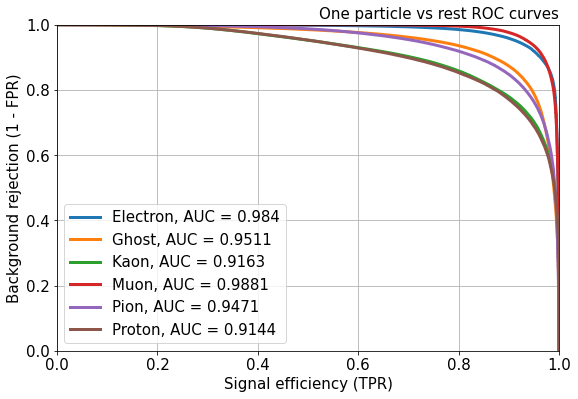

In [14]:
utils.plot_roc_curves(proba, validation_data.Class.values)

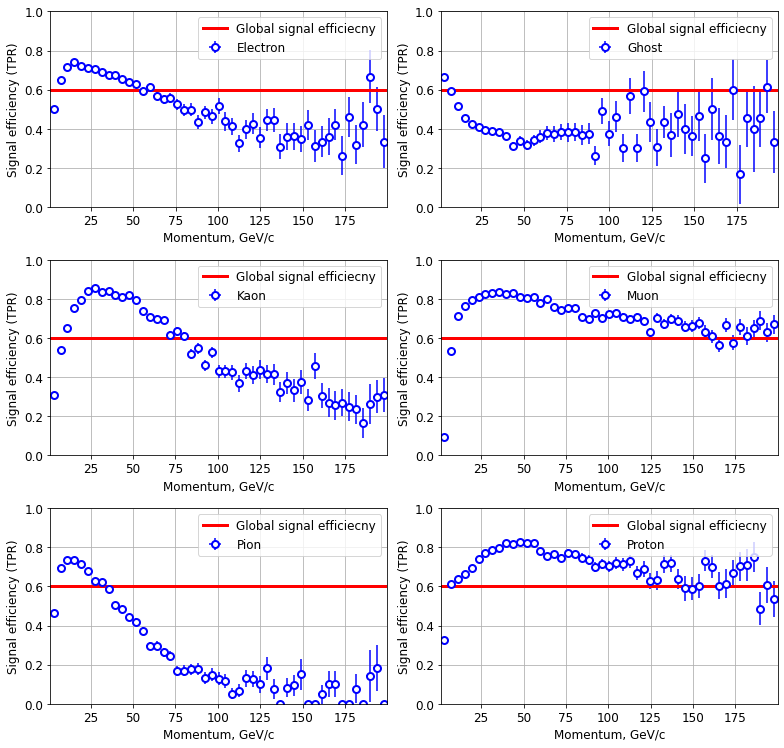

In [15]:
utils.plot_signal_efficiency_on_p(proba, validation_data.Class.values, validation_data.TrackP.values, 60, 50)
plt.show()

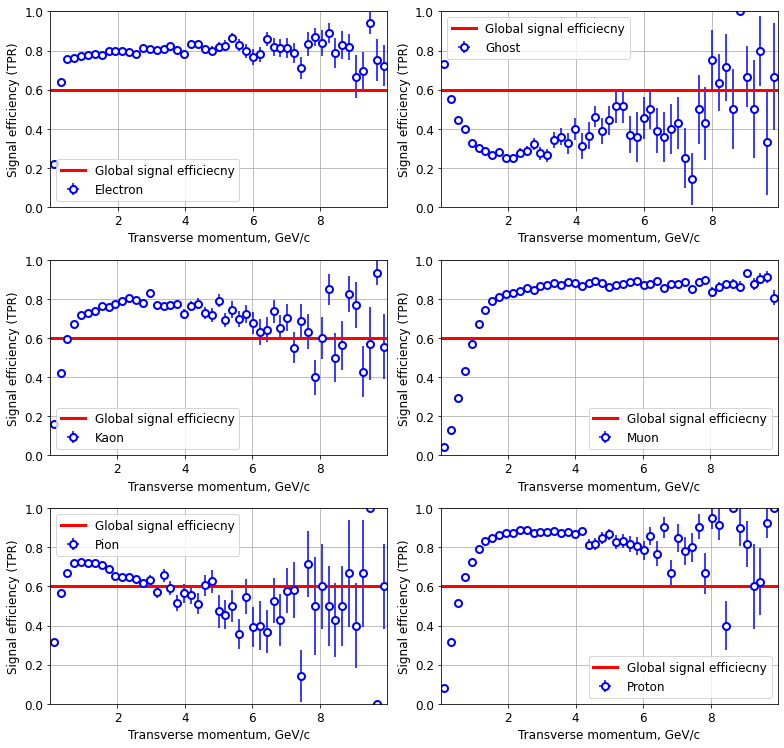

In [16]:
utils.plot_signal_efficiency_on_pt(proba, validation_data.Class.values, validation_data.TrackPt.values, 60, 50)
plt.show()

# Applying the classifier on the test data 

Now it's time to put all of this to use!

In [17]:
test = pandas.read_csv('test.csv.gz')

In [18]:
proba = gb.predict_proba(test[features])*100
ids = test.ID

In [19]:
from IPython.display import FileLink
utils.create_solution(ids, proba, filename='test_obs_file.csv.gz')

/home/centarsirius/Documents/MLH_showcase/test_obs_file.csv.gz

In [20]:
result = pandas.read_csv('test_obs_file.csv.gz')

This file lists the probability of the particle being any one of the particle types for each run. To actually omit any vaue it should have atleast 5σ error (233 errors per million or 99.97% accuracy), so i have included all the probabilities.

In [21]:
result.head()

,ID,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0,0.53496,0.27251,0.38534,0.71750,9.03635,89.05333
1,1,15.56873,0.77129,3.64191,4.07659,46.79138,29.15010
2,2,4.27114,2.13979,3.35643,48.44246,22.91183,18.87835
3,3,1.21071,16.50026,70.35102,4.04201,4.64635,3.24964
4,4,4.97036,73.98072,0.87491,9.29824,4.33848,6.53729


Highest probability for each particle in the whole run

In [22]:
highest_prob= result.max(axis=0)
print(highest_prob[1:6])

Ghost       98.11385
Electron    98.64138
Muon        99.30649
Pion        98.75553
Kaon        98.79581
dtype: float64
